## Stardist connect-in-2d to create 3D training data

In this notebook we simulate the process of creating 3D training data by the following procedure

1.  Create a 3D simulated image of spheres
2.  (Optionally) add a slight random shift to simulate 3D drift
3.  Apply 2D stardist to each plane
4.  Connect the 2d planes in 3D 

## Dependencies

### Install development version of tnia-python from git

```
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python.git
```

### Or clone tnia-python from git and install in interactive mode

```
git clone https://github.com/True-North-Intelligent-Algorithms/tnia-python
```

Navigate to the directory with tnia-python and type

pip install -e .

### Install stardist

#### Windows

```
    pip install numpy==1.26
    conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
    pip install "tensorflow<2.11"
    pip install stardist==0.8.5
    pip install gputools
    pip install edt
```

#### Linux

```
    pip install numpy==1.26
    pip install tensorflow[and-cuda]
    pip install stardist
    pip install gputools
    pip install edt
```

### Additional

```
pip install raster-geometry
```


In [7]:
from tnia.plotting.projections import show_xy_zy_max, show_xy_zy_slice_center
from tnia.simulation.phantoms import random_sphere_phantom
from tnia.deconvolution.forward import forward
from pathlib import Path
from tnia.deeplearning.dl_helper import make_patch_directory, stardist_2d_slicewise
from tnia.deeplearning.augmentation import random_shift_slices_in_stack
from skimage.io import imsave
from tnia.morphology.connect import connect_2d_in_3d
from csbdeep.utils import normalize
import os

## Setup paths

In [11]:

tnia_images_path = Path("D:/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2024_01_30_connect2d_in3d"
patches_path = parent_path / "patches8"

images_paths, truth_paths=make_patch_directory(1,1,patches_path)

images_path = Path(images_paths[0])
truth_path = Path(truth_paths[0])

simulated_truth_path = patches_path / "simulated_truth"

if not simulated_truth_path.exists():
    # create simulated truth path
    os.makedirs(simulated_truth_path, exist_ok=True)
    
print('images path', images_path)
print('ground truth path', truth_path)

images path D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches8\input0
ground truth path D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches8\ground truth0


## Create a 3D point spread function

This will be used to add some blur to the simulated image

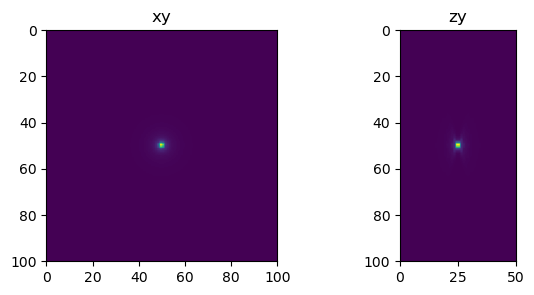

In [12]:
from tnia.deconvolution.psfs import gibson_lanni_3D

psf = gibson_lanni_3D(1.4, 1.5, 1.3, .1, .3, 100, 50, 0, .5, False, True)

fig = show_xy_zy_max(psf, figsize=(7,3))

## Import stardist 

... and load the pretrained fluo model

In [13]:
from stardist.models import StarDist2D

# pretrained fluo
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


## Generate image/ground truth pairs

1.  Create a phantom containing random spheres
2.  Apply blur and noise
3.  Apply a random shift to each slice
4.  Normalize the image (in preparation for deep learning training)
5.  Apply 2D Stardist slicewise on the 3D image
6.  Connect the 2D labels in 3D

(100, 300, 300)
img shifted size (100, 296, 296)


100%|██████████| 99/99 [00:00<00:00, 170.79it/s]
2937160088.py (28): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches7\ground truth0\image_0.tif is a low contrast image


(100, 300, 300)
img shifted size (100, 296, 296)


100%|██████████| 99/99 [00:00<00:00, 171.02it/s]
2937160088.py (28): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches7\ground truth0\image_1.tif is a low contrast image


(100, 300, 300)
img shifted size (100, 296, 296)


100%|██████████| 99/99 [00:00<00:00, 168.48it/s]
2937160088.py (28): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches7\ground truth0\image_2.tif is a low contrast image


(100, 300, 300)
img shifted size (100, 296, 296)


100%|██████████| 99/99 [00:00<00:00, 174.99it/s]
2937160088.py (28): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches7\ground truth0\image_3.tif is a low contrast image


(100, 300, 300)
img shifted size (100, 296, 296)


100%|██████████| 99/99 [00:00<00:00, 184.51it/s]
2937160088.py (28): D:\images\tnia-python-images\imagesc\2024_01_30_connect2d_in3d\patches7\ground truth0\image_4.tif is a low contrast image


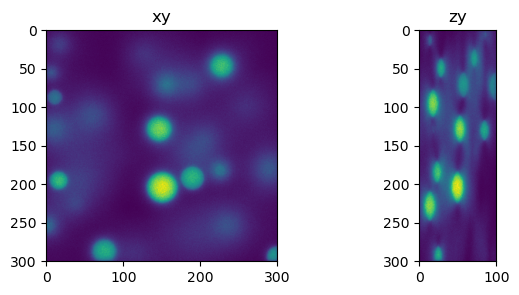

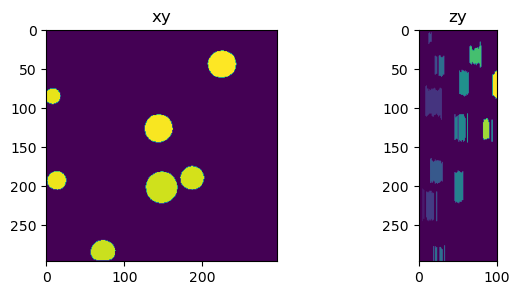

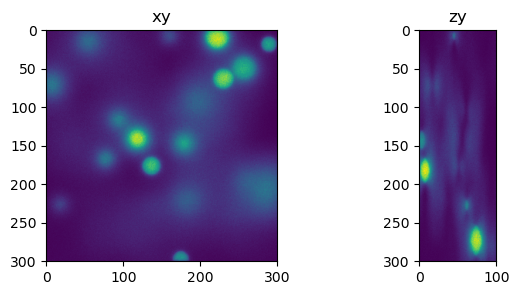

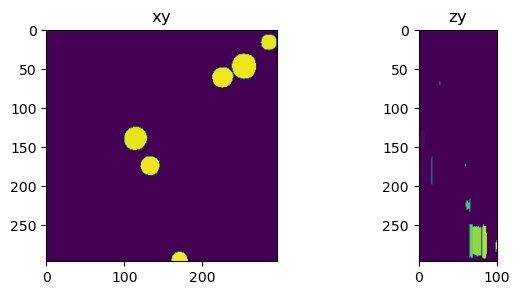

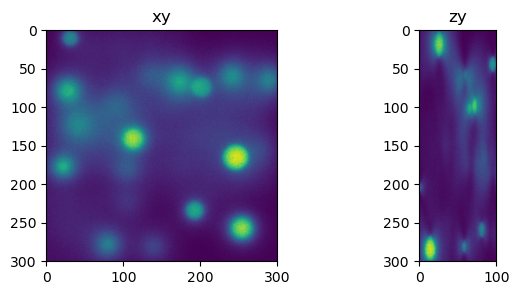

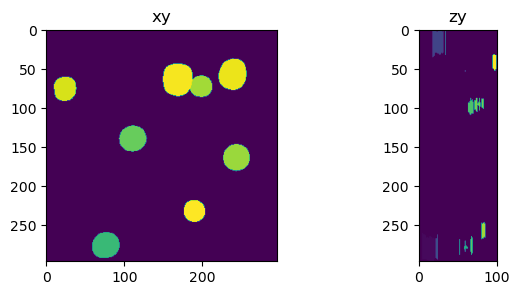

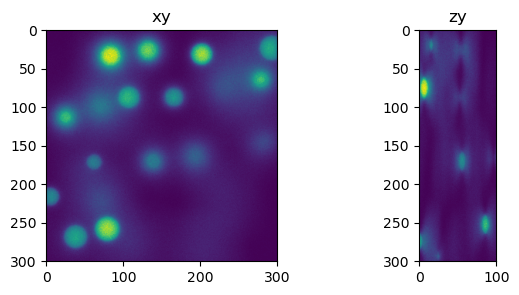

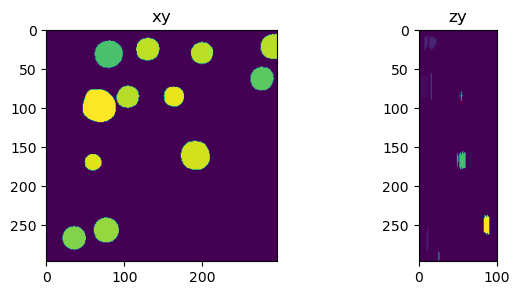

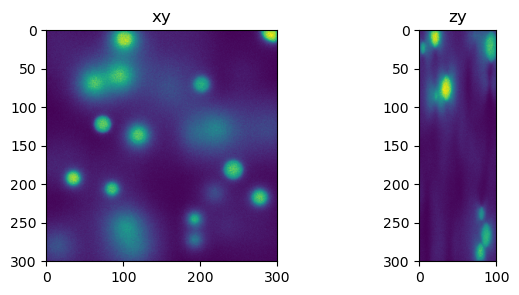

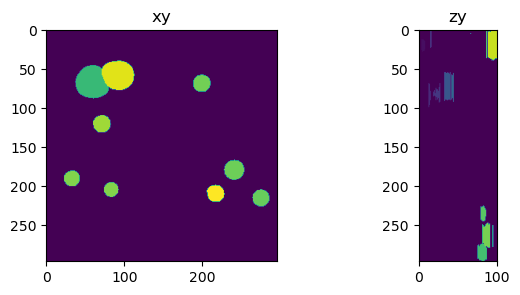

In [5]:
ground_truths = []
images = []
labels = []

for i in range(5):
    # create a random sphere phantom
    ground_truth = random_sphere_phantom(300,300,300, 100, 10, 20, None, 100, 200)
    ground_truth = ground_truth[::3, :, :]
    print(ground_truth.shape)
    imsave(simulated_truth_path / f"image_{i}.tif", ground_truth)
    ground_truths.append(ground_truth)

    # apply forward imaging model (blur and noise)
    img_forward = forward(.1*ground_truth, psf, 10, True, True)
    images.append(img_forward)
    # apply random shift to slices
    img_shifted = random_shift_slices_in_stack(img_forward, 2)
    print('img shifted size', img_shifted.shape)
    img_normalized = normalize(img_shifted, 0,100)
    
    # apply stardist 2d slicewise then connect in 3D
    labeled = stardist_2d_slicewise(img_normalized, model, perform_normalization=False, use_tqdm=True, prob_thresh=0.85)
    labeled_connected = connect_2d_in_3d(labeled, 5, use_tqdm=True)
    
    labels.append(labeled_connected)
    
    imsave(images_path / f"image_{i}.tif", img_shifted)
    imsave(truth_path / f"image_{i}.tif", labeled_connected)
    fig = show_xy_zy_slice_center(img_forward, figsize=(7,3))
    fig = show_xy_zy_slice_center(labeled_connected, figsize=(7,3))

## View one of the image/ground truth pairs in Napari

In [47]:
import napari
viewer = napari.Viewer()
viewer.add_image(img_shifted, name='image')
viewer.add_labels(ground_truth.astype('uint16'), name='ground truth')
viewer.add_labels(labeled_connected, name = '2d connect in 3d labels')

<Labels layer '2d connect in 3d labels' at 0x27363bd6130>

In [6]:
img_shifted.shape, labeled_connected.shape

((100, 296, 296), (100, 296, 296))